In [1]:
import os
import sys
import glob
import math
import pandas as pd
import subprocess
from multiprocessing import Pool
import multiprocessing 
from collections import Counter

from matplotlib import cm
import matplotlib
import umap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from biopandas.pdb import PandasPdb

sys.path.append('../../hamp_pred/')
from utils.tools import diffangle


data_dir = '../../data/input'

2023-10-18 14:06:46.921783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 14:06:47.054489: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 14:06:47.671508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-18 14:06:47.671596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    #plt.register_cmap(cmap=newcmap)

    return newcmap

# Read data

### AF2 models

In [3]:
# get group names
hamp_groups_df = pd.read_csv('../../../TCST/offline_data/hamp/groupnames.csv', names=['paper_group', 'group'])
hamp_groups_df['group'] = hamp_groups_df['group'].apply(lambda x:x.replace('.fas', ''))
paper2group = dict(hamp_groups_df.values) #my_array
group2paper = dict(hamp_groups_df.values[:, [1, 0]])

NEW_RUN = '_newrun'
#NEW_RUN = ''

# get measured structures from af2
data_df = pd.read_pickle(os.path.join(data_dir, f'af2{NEW_RUN}.p'))
data_df.group = data_df.group.apply(lambda x:group2paper[x] if x in group2paper else '?')
len(data_df)

5314

In [4]:
CLEAN = True

In [5]:
# remove background sequences
#if CLEAN:
#    data_df = data_df[data_df.group != '?']

In [6]:
# calculate the relative rotation (i.e., the per-layer difference between N and C helices rotation) 
data_df['rot'] = diffangle(data_df.n_crick_mut, data_df.c_crick_mut)
data_df['rot_mean'] = data_df['rot'].apply(np.mean)
data_df['rot_std'] = data_df['rot'].apply(np.std)
data_df['sequence'] = data_df['n_seq'] + data_df['c_seq'] # for mmseqs2 clustering

len(data_df)

5314

In [7]:
#data_df[~data_df.apply(check_crick, axis=1)].group.value_counts()

In [8]:
# referece Crick angles
crangles = {'a':19.5,'b':122.35,'c':-134.78,'d': -31.92,'e':70.92 ,'f':173.78,'g':-83.35}

def check_crick(row, MAXROT=55):
    return (np.abs(diffangle(row.n_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) and \
           (np.abs(diffangle(row.c_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) 

if CLEAN:
    data_df = data_df[data_df.apply(check_crick, axis=1)]
len(data_df)

5116

In [9]:
if CLEAN:
    data_df = data_df[data_df.rot_mean.abs() <= 52]
len(data_df)

5094

### PDB structures

In [10]:
data_df_exp = pd.read_pickle(os.path.join(data_dir, 'pdb_measure.p'))
data_df_exp = data_df_exp[['n_rot', 'c_rot', 'mutant', 'rot', 'rot_mean', 'rot_std', 'seq1', 'seq2']]

data_df_exp = data_df_exp[data_df_exp.mutant==False]
data_df_exp = data_df_exp.drop('mutant', axis=1)

data_df_exp['group'] = 'PDB'
data_df_exp['pdb_file'] = [i.split("_")[1] for i in data_df_exp.index]

data_df_exp.at['22_4i3m.pdb', 'pdb_file'] = '4i3m_1.pdb'
data_df_exp.at['23_4i3m.pdb', 'pdb_file'] = '4i3m_2.pdb'
data_df_exp.at['24_4i3m.pdb', 'pdb_file'] = '4i3m_3.pdb'

data_df_exp.at['25_3lnr.pdb', 'pdb_file'] = '3lnr_1.pdb'
data_df_exp.at['26_3lnr.pdb', 'pdb_file'] = '3lnr_2.pdb'
data_df_exp.at['27_3lnr.pdb', 'pdb_file'] = '3lnr_3.pdb'

data_df_exp.at['28_4i44.pdb', 'pdb_file'] = '4i44_1.pdb'
data_df_exp.at['29_4i44.pdb', 'pdb_file'] = '4i44_2.pdb'
data_df_exp.at['30_4i44.pdb', 'pdb_file'] = '4i44_3.pdb'

len(data_df_exp)


31

In [11]:
data_df_exp_copy = data_df_exp.copy()

In [12]:
data_df=pd.concat([data_df, data_df_exp])

#data_df = data_df_exp

In [13]:
data_df.reset_index(drop=True, inplace=True)


# Run FoldSeek

In [15]:
# get symlinks to all pdb files

# af2 models
pdb_dir = f'/home/users/sdunin/calc/HAMPpred/data/input/af2_full{NEW_RUN}/'

# pdb structures
exp_dir = '/home/users/sdunin/calc/HAMPpred/data/input/struct_in/'

# structures for FoldSeek
clust_dir = f'/home/users/sdunin/calc/TCST/HAMP_AF2_cluster{NEW_RUN}/'
ln_dir = clust_dir + '/pdbs'

#f = open(os.path.join(clust_dir, 'chain_list'), 'w')

for _, row in tqdm(data_df.iterrows(), total=len(data_df)):
    
    if row.group == 'PDB':
        os.system(f'ln -sf {os.path.join(exp_dir,row.pdb_file)} {ln_dir}')
        #print(row.pdb_file)
    else:   
        pass
        #os.system(f'ln -sf {os.path.join(pdb_dir,row.pdb_file)} {ln_dir}')
    
    #f.write(f'{os.path.basename(row.pdb_file)}\n')
     
#f.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5156/5156 [00:01<00:00, 3818.56it/s]


In [36]:
len(data_df[data_df.group=='PDB'])

31

In [48]:
# merge chains 
in_pdbs = f'/home/users/sdunin/calc/TCST/HAMP_AF2_cluster{NEW_RUN}/pdbs/'

def merge_chains(pdb1, pdb2):
    
    model = PandasPdb().read_pdb(pdb1)
    # keep only ATOMs
    model._df = {'ATOM':model.df['ATOM']}
    model_df = model.df['ATOM']
    
    # there should be 2 unique chains
    assert len(model_df.chain_id.unique())==2, pdb1
    
    # model_df = model_df[model_df.chain_id.isin(['A', 'B'])]

    # Calculate res_count
    res_count = model_df[model_df.chain_id == 'A']['residue_number'].max()

    # Iterate through rows where chain_id is 'B'
    for res_id, g in model_df[model_df.chain_id == 'B'].groupby('residue_number'):
        model_df.loc[g.index, 'residue_number'] = res_id + res_count

    ca_residue_numbers = model_df[model_df.atom_name == 'CA']['residue_number']
    
    unique_values, counts = np.unique(ca_residue_numbers, return_counts=True)
    duplicates = unique_values[counts > 1]
    
    assert ca_residue_numbers.is_unique, (pdb1, res_count, duplicates)
    assert ca_residue_numbers.is_monotonic_increasing, pdb1

    model_df.chain_id = 'A'

    model.to_pdb(path=pdb2, 
            records=None, 
            gz=False, 
            append_newline=True)
    
    

    

In [49]:
# inpdb = '/home/users/sdunin/calc/TCST/HAMP_AF2_cluster_newrun/pdbs/2l7i.pdb'
# outpdb = '/home/users/sdunin/calc/TCST/HAMP_AF2_cluster_newrun/pdbs_onechain/2l7i.pdb'

# merge_chains(inpdb, outpdb)

In [54]:
    
for in_pdb in tqdm(glob.glob(os.path.join(in_pdbs, '*.pdb'))):
    
    if len(os.path.basename(in_pdb)) > 11: continue
    
    out_pdb = in_pdb.replace('/pdbs/', '/pdbs_onechain/')    
    model_df= merge_chains(in_pdb, out_pdb)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5125/5125 [00:02<00:00, 2182.56it/s]


In [229]:
# run foldseek in /home/users/sdunin/calc/TCST/HAMP_AF2_cluster_newrun

# Read FoldSeek results

In [14]:
clu_results = f'/home/users/sdunin/calc/TCST/HAMP_AF2_cluster{NEW_RUN}/aln_exhaustive_at1.csv'

cols = ['query','target','alnlen','evalue','alntmscore','prob', 'lddt', 'rmsd']

res_df = pd.read_csv(clu_results, names=cols, usecols=cols, sep='\t')
res_df.head()

,query,target,alnlen,evalue,alntmscore,prob,lddt,rmsd
0,hamp_5856_BACKGROUND_unrelaxed_rank_001_alphaf...,hamp_5856_BACKGROUND_unrelaxed_rank_001_alphaf...,106,1.0000,1.0000,1.000,1.0000,0.0000
1,hamp_5856_BACKGROUND_unrelaxed_rank_001_alphaf...,hamp_670_A_mgroup_102_unrelaxed_rank_001_alpha...,106,0.9772,0.9842,0.999,0.9348,0.5877
2,hamp_5856_BACKGROUND_unrelaxed_rank_001_alphaf...,hamp_315_A_group_44_unrelaxed_rank_001_alphafo...,106,0.9750,0.9826,0.999,0.9376,0.6182
3,hamp_5856_BACKGROUND_unrelaxed_rank_001_alphaf...,hamp_5120_BACKGROUND_unrelaxed_rank_001_alphaf...,106,0.9739,0.9818,0.999,0.9309,0.6345
4,hamp_5856_BACKGROUND_unrelaxed_rank_001_alphaf...,hamp_281_A_group_44_unrelaxed_rank_001_alphafo...,106,0.9677,0.9775,0.999,0.9245,0.7054


In [15]:
# check if all pdb structures were clustered
tmp_df = res_df[(~res_df['target'].str.startswith('hamp_')) | (~res_df['query'].str.startswith('hamp_'))]
tmp = np.concatenate([
    tmp_df['query'].values,
    tmp_df['target'].values
])
tmp = tmp.astype(str)
assert len(np.unique(tmp[~np.char.startswith(tmp, 'hamp_')])) == len(data_df_exp)

In [16]:
# map af2 model name / pdb name to data_df index
pdb2idx = {v.split('/')[1] if '/' in v else v: k for k, v in zip(data_df.index, data_df['pdb_file'])}

In [17]:
# map to data_df indexes
res_df['i'] = res_df['query'].apply(lambda x:pdb2idx[x] if x in pdb2idx else -1)
res_df['j'] = res_df['target'].apply(lambda x:pdb2idx[x] if x in pdb2idx else -1)
pre_len = len(res_df)
print(pre_len)
# remove hits that involve structures that are not in data_df
res_df = res_df[(res_df['i'] != -1) & (res_df['j'] != -1)]
post_len = len(res_df)
if not CLEAN: assert pre_len == post_len
print(len(res_df))

26241643
26241643


### Create matrix

In [43]:
matrix_df = res_df.pivot(index='i', columns='j', values='lddt')

In [51]:
matrix_array = matrix_df.to_numpy()
matrix_array[np.isnan(matrix_array)] = 0
assert matrix_array.shape[0] == matrix_array.shape[1] == len(data_df)


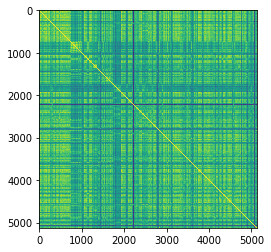

In [52]:
plt.imshow(matrix_array, cmap='viridis', interpolation='nearest')

# Plot

### Reduce with UMAP

In [96]:
# If the metric is ‘precomputed’ X must be a square distance matrix. 
umap_result = umap.UMAP(
    n_neighbors = 200, 
    metric = 'precomputed',
    random_state = 123456
).fit_transform(1-matrix_array)


/home/users/sdunin/miniconda3/envs/jup/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


### Color by features

In [97]:
def feature_colors(mode, z_score_cut=3):
    
    assert mode in ['shift', 'rotation', 'romboid', 'angle']

    if mode == 'shift':
        title = "Shift between N- and C-terminal helices [Å]"
    elif mode == 'rotation':
        title = 'Axial rotation of all helices [°]'
    elif mode == 'romboid':
        title = 'Difference between $n_1$ and $n_2$ [Å]'
    elif mode == 'angle':
        title = 'Bundle periodicity'

    def enc(row, mode):

        if row['group'] == 'PDB': return np.nan
        
        if mode == 'shift':
            return (row.n_shift - row.c_shift) / 2
        elif mode == 'rotation':
            return diffangle(row.n_crick_mut , row.c_crick_mut).mean() / 2

        elif mode == 'romboid':
            return row.n_radius - row.c_radius

        elif mode == 'angle':
            return np.mean([row.n_P,row.c_P])

        #a = row.rot
        #return np.mean((a[0::2] + a[1::2]) / 2) / 2


    c = [enc(data_df.loc[i], mode=mode) for i in matrix_df.index]
    c = np.array(c)

    # remove outliers
    z_scores = (c - np.nanmean(c)) / np.nanstd(c)
    
    correct_mask = (abs(z_scores) <= z_score_cut) & ~np.isnan(c)
    
    print(f'{len(z_scores) - np.sum(correct_mask)} points removed...')
    
    c = c[correct_mask]

    # define cmap centered at data mean
    cmap = cm.seismic
    min_value = min(c)
    max_value = max(c)
    c_scaled = [(x - min_value) / (max_value - min_value) for x in c]
    cmap = shiftedColorMap(cmap, midpoint=np.mean(c_scaled), name='seismic_new')

    return c,correct_mask, cmap, title


### Color by groups

In [98]:
def groups_colors(gr, z_score_cut):

    # define colors for groups defined in 'gr'
    def assign_colors_to_strings(group_labels, group_colors, X=1):
        color_dict = {}

        for g in group_labels:
            if g in group_colors:
                color_dict[g] = group_colors[g]
            else:
                color_dict[g] = 'grey'

        colors = [color_dict[g] for g in group_labels]

        return colors

    group_labels = [data_df.loc[i].group for i in matrix_df.index]
    c = assign_colors_to_strings(group_labels, gr, X=10)
    c = np.array(c)
    
    # mask outliers (probable alignment errors)
    full_pos = np.array(range(len(matrix_df.index)))
    to_remove = []
    
    # groups
    for g in gr:
        # positions (not indexes) of sequences from group `g`        
        pos = np.where(c == gr[g])[0]
        
        # cooridnates in the UMAP space
        x = umap_result[pos, 0]
        y = umap_result[pos, 1]
        
        # outlier detection
        z_scores_x = (x - np.mean(x)) / np.std(x)
        z_scores_y = (y - np.mean(y)) / np.std(y)
        
        tr = pos[
            (np.abs(z_scores_x) > z_score_cut) | (np.abs(z_scores_y) > z_score_cut)
        ]
        
        for tmp in tr: 
            assert not tmp in to_remove
            assert tmp in full_pos, tmp
            
        to_remove.extend(tr)
     
    assert len(set(to_remove)) == len(to_remove)
    print(f'{len(to_remove)} points will be removed from {len(gr)} groups...')
                
    mask = np.isin(full_pos, to_remove, invert=True)
    #c = c[mask]
    
    return c, mask


### Plot

In [99]:
# color by groups

# B        300 B, F2-B
# C.1      155
# A.28     145
# D        130
# F.2      107 F2-B 
# A.48      56

gr = {    
    'B':'limegreen', 
    'F.2':'orange', 
    'A.28':'skyblue',
    'D':'violet',
    'G.1':'cyan',
    'F.6':'red',
    'C.1':'royalblue', 
}  

c, correct_mask = groups_colors(gr, z_score_cut=3)
cmap = None

10 points will be removed from 7 groups...


In [100]:
c = (len(data_df) - len(data_df_exp_copy))*['grey'] 

for pdbid, pdbrow in data_df_exp_copy.iterrows():
    if pdbid in [
        '0_2l7h.pdb', '1_2l7i.pdb', '2_2y0q.pdb', '3_2y20.pdb', '4_2y21.pdb',
        '5_4gn0.pdb', '6_4cq4.pdb', '12_3zrx.pdb', '13_3zrv.pdb',
        '14_3zrw.pdb', '15_3zcc.pdb', '16_2lfr.pdb', '17_2lfs.pdb',
        '18_4cti.pdb', '20_3zx6.pdb'
    ]:
        c.append('red')
    
    elif pdbid in ['7_5iji.pdb', '8_5jeq.pdb', '9_5jef.pdb', '10_5jgp.pdb', '11_6yue.pdb']:
        c.append('green')
    
    elif pdbid in ['22_4i3m.pdb', '25_3lnr.pdb', '28_4i44.pdb']:
        c.append('lightgreen')        
   
    elif pdbid in ['23_4i3m.pdb', '26_3lnr.pdb', '29_4i44.pdb']:
        c.append('lightblue')   
        
    elif pdbid in ['24_4i3m.pdb', '27_3lnr.pdb', '30_4i44.pdb']:
        c.append('orange')  
        
    elif pdbid in ['19_4biv.pdb', '31_4biu.pdb']:
        c.append('blue') 
        
    elif pdbid in ['21_4i5s.pdb']:
        c.append('pink') 

    else:
        c.append('black')

c = np.asarray(c)
len(c), len(data_df)

(5125, 5125)

In [101]:
# color by feature
c, correct_mask, cmap, title = feature_colors('shift', z_score_cut=3)
len(c)

77 points removed...


5048

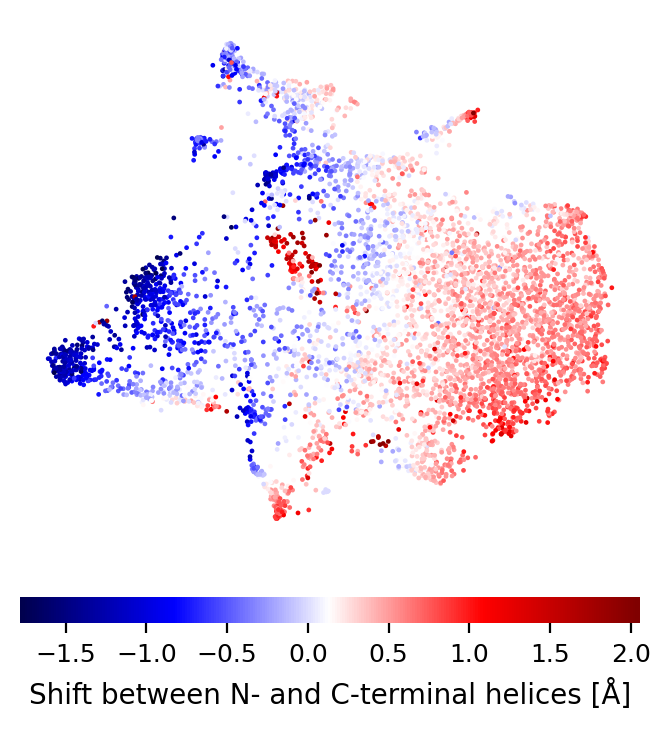

In [102]:
label_font_size = 10
tick_font_size = 9 # bar
title_font_size = 10


# plotting structural features with colormap
if cmap is not None:
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
    ax.set_axis_off()
    
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 0.05])
    ax = fig.add_subplot(gs[0])
    ax.set_axis_off()
    
    scatter = ax.scatter(umap_result[correct_mask, 0], umap_result[correct_mask, 1], s=0.5, c=c, cmap=cmap) 
    
    # Create the color bar
    cbar_ax = fig.add_subplot(gs[1])
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=tick_font_size)  
    cbar.set_label(title, fontsize=title_font_size)    
    cbar.outline.set_linewidth(0)

# ploting categories (e.g. families) without colormap
else:
    
    if len(gr)==1:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
        
    ax.set_axis_off()

    non_grey_indices = (c != 'grey') & correct_mask
    grey_indices = (c == 'grey') & correct_mask
    
    scatter = plt.scatter(umap_result[grey_indices, 0], umap_result[grey_indices, 1], s=4, c=c[grey_indices], zorder=0,
                        alpha=0.3, edgecolor='none')    
    
    # more than one group (famillies)
    #if len(gr)>1:
        
    scatter = plt.scatter(umap_result[non_grey_indices, 0], umap_result[non_grey_indices, 1], s=16, c=c[non_grey_indices],
                         edgecolor='black', linewidth=0.5)

    # show PDB structures labels
    if False:
                
        pdb_df = data_df_exp_copy.copy()
        pdb_df['umap_idx'] = range(len(data_df)-len(data_df_exp), len(data_df))
        
        for pdbid, pdbrow in pdb_df.iterrows():

            if pdbid in pdb2name:
                name = pdb2name[pdbid]
            else:
                name = ''
                
            #print(f'{name} {pdbid} {pdbrow.umap_idx}')

            ax.text(umap_result[pdbrow.umap_idx, 0], umap_result[pdbrow.umap_idx, 1], name, fontsize=8, color='red')

            
#         # draw arrows between af1503 mutants
#         pdb_df = data_df_exp_copy.copy()
#         pdb_df['desc'] = [pdb2name[i] if i in pdb2name else '' for i in pdb_df.index]
#         pdb_df['umap_idx'] = range(len(data_df)-len(data_df_exp), len(data_df))
#         #pdb_df = pdb_df[pdb_df.desc!='']
#         #pdb_df = pdb_df.set_index('desc')
#         #pdb_df = pdb_df[pdb_df.desc.isin(['Af1503 A291C', 'Af1503 WT', 'Af1503 A291V', 'Af1503 A291I', 'Af1503 A291F'])]

#         window_size = 2
#         for window in pdb_df.rolling(window=window_size):
#             if len(window) == window_size:
#                 # Process the window of 2 rows here
#                 x,y=umap_result[window.iloc[0].umap_idx]
#                 a,b=umap_result[window.iloc[1].umap_idx]
#                 ax.arrow(x, y, a - x, b - y, head_width=0.1, head_length=0.1, fc='black', ec='black',
#                         length_includes_head=True, zorder=2)
                
#                 ax.plot(a, b, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="red", zorder=1)
#                 ax.plot(x, y, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="red", zorder=1)




#plt.tight_layout()


In [82]:
# mark experimental structures from PDB

pdb2name={
    
 #   '0_2l7h.pdb': 'Af1503 WT',
 #'1_2l7i.pdb': 'Af1503 A291F',
 #'2_2y0q.pdb': 'Af1503 A291C',
 #'3_2y20.pdb': 'Af1503 A291I',
 #'4_2y21.pdb': 'Af1503 A291V',
 #'5_4gn0.pdb': 'Af1503 WT',
 #'6_4cq4.pdb': 'Af1503 WT',
 #'7_5iji.pdb': 'NarQ',
 #'8_5jeq.pdb': 'NarQ',
 #'9_5jef.pdb': 'NarQ',
 #'10_5jgp.pdb': 'NarQ',
 #'11_6yue.pdb': 'NarQ',
#  '12_3zrx.pdb': 'Af1503 A291F+DHp(EnvZ)',
#  '13_3zrv.pdb': 'Af1503 A291F+DHp(EnvZ)',
#  '14_3zrw.pdb': 'Af1503 A291V+DHp(EnvZ)',
#  '15_3zcc.pdb': 'Af1503 WT+DHp(EnvZ)R333G ',
#  '16_2lfr.pdb': 'Af1503 WT+DHp(EnvZ)',
#  '17_2lfs.pdb': 'Af1503 A291F+DHp(EnvZ)',
#  '18_4cti.pdb': 'Af1503 A291F+DHp(EnvZ)',
 # '19_4biv.pdb': 'CpxA',
#  '20_3zx6.pdb': 'AF1503 A291V+MA(Tsr)',
#  '21_4i5s.pdb': 'VicK',
  #'22_4i3m.pdb': 'Aer2_1_m1',
  #'23_4i3m.pdb': 'Aer2_2_m1',
 #'24_4i3m.pdb': 'Aer2_3_m1',
  #'25_3lnr.pdb': 'Aer2_1',
  #'26_3lnr.pdb': 'Aer2_2',
  #'27_3lnr.pdb': 'Aer2_3',
  #'28_4i44.pdb': 'Aer2_1_m2',
  #'29_4i44.pdb': 'Aer2_2_m2',
#  '30_4i44.pdb': 'Aer2_3_m2',
 #'31_4biu.pdb': 'CpxA'
        
         }

gr = {    
    'PDB':'red' 
}  

_, correct_mask = groups_colors(gr, z_score_cut=200)


assert sum(c=='red') == len(data_df_exp)
cmap = None

0 points will be removed from 1 groups...


In [43]:
data_df[data_df.group=='PDB'].sort_values(by='rot_mean')

,group,n_rot,c_rot,rot,n_seq,c_seq,n_crick_mut,c_crick_mut,full_seq,pdb_file,...,c_radius,n_A,c_A,n_P,c_P,rot_mean,rot_std,sequence,seq1,seq2
0_2l7h.pdb,PDB,-19.296311,8.163004,"[-21.763853269264587, -24.365479228916485, -21...",NaN,NaN,NaN,NaN,NaN,2l7h.pdb,...,NaN,NaN,NaN,NaN,NaN,-27.459314,4.259076,NaN,PIIELSNTADKIA,EIGILAKSIERLR
3_2y20.pdb,PDB,-18.736343,7.062672,"[-33.384661991503464, -31.152899060893105, -36...",NaN,NaN,NaN,NaN,NaN,2y20.pdb,...,NaN,NaN,NaN,NaN,NaN,-25.799014,6.038796,NaN,PIIELSNTIDKIA,EIGILAKSIERLR
4_2y21.pdb,PDB,-17.299223,3.459582,"[-24.579113703730542, -23.675297459831313, -25...",NaN,NaN,NaN,NaN,NaN,2y21.pdb,...,NaN,NaN,NaN,NaN,NaN,-20.758804,3.242909,NaN,PIIELSNTVDKIA,EIGILAKSIERLR
2_2y0q.pdb,PDB,-17.979150,1.242494,"[-21.791881161870975, -26.72395697889641, -23....",NaN,NaN,NaN,NaN,NaN,2y0q.pdb,...,NaN,NaN,NaN,NaN,NaN,-19.221644,4.166560,NaN,PIIELSNTCDKIA,EIGILAKSIERLR
23_3lnr.pdb,PDB,-7.711330,10.815936,"[3.8522117857427816, 3.8522117857427816, -11.2...",NaN,NaN,NaN,NaN,NaN,3lnr_3.pdb,...,NaN,NaN,NaN,NaN,NaN,-18.527266,8.306609,NaN,VKMKVVSVVTAYG,KKAQITEAIDGVR
5_5iji.pdb,PDB,-4.087357,7.779974,"[-16.715658630383103, -16.71565355119671, -14....",NaN,NaN,NaN,NaN,NaN,5iji.pdb,...,NaN,NaN,NaN,NaN,NaN,-11.867330,3.992330,NaN,PLNQLVTASQRIE,ELGLLAKTFNQMS
21_3lnr.pdb,PDB,-4.326787,5.352000,"[4.170755811044813, 4.170755811044785, -6.9937...",NaN,NaN,NaN,NaN,NaN,3lnr_1.pdb,...,NaN,NaN,NaN,NaN,NaN,-9.678787,7.631665,NaN,RADRIATLLQSFA,GYERLYDSLRALQ
1_2l7i.pdb,PDB,0.212011,3.933485,"[-1.5700224541745627, -1.8857391013366964, -2....",NaN,NaN,NaN,NaN,NaN,2l7i.pdb,...,NaN,NaN,NaN,NaN,NaN,-3.721474,2.435628,NaN,PIIELSNTFDKIA,EIGILAKSIERLR
20_4i5s.pdb,PDB,-9.233917,-8.081222,"[16.40442658865655, -0.7818740290976507, 5.452...",NaN,NaN,NaN,NaN,NaN,4i5s.pdb,...,NaN,NaN,NaN,NaN,NaN,-1.152695,7.464071,NaN,QVKQLNAKVRSLI,DLSELVNNVNDLS
16_4biv.pdb,PDB,6.374830,-10.497030,"[21.146410642958585, 21.1171257389272, 11.1408...",NaN,NaN,NaN,NaN,NaN,4biv.pdb,...,NaN,NaN,NaN,NaN,NaN,16.871860,6.132316,NaN,PARKLKNAADEVA,EFLAAGASFNQMV


In [109]:
# measure correlations

In [111]:
v = []
for feature in ['shift', 'rotation', 'angle', 'romboid']:
    print(feature)
    c, _, _, _ = feature_colors(feature, z_score_cut=100)
    v.append(c)

v = np.array(v)
assert v.shape[1] == umap_result.shape[0] - 11

shift
11 points removed...
rotation
11 points removed...
angle
11 points removed...
romboid
11 points removed...


In [167]:
np.corrcoef(v)

array([[ 1.        ,  0.55026062,  0.29460744, -0.22878873],
       [ 0.55026062,  1.        ,  0.17985949, -0.06079459],
       [ 0.29460744,  0.17985949,  1.        ,  0.23051765],
       [-0.22878873, -0.06079459,  0.23051765,  1.        ]])

In [112]:
from scipy.stats import spearmanr

correlation_matrix, pvals = spearmanr(v, axis=1)

print(correlation_matrix)

[[ 1.          0.55744264  0.21383511 -0.30322411]
 [ 0.55744264  1.          0.17863131 -0.19104741]
 [ 0.21383511  0.17863131  1.          0.24339676]
 [-0.30322411 -0.19104741  0.24339676  1.        ]]


In [113]:
print(pvals)

[[0.00000000e+000 0.00000000e+000 9.22482697e-054 8.30976576e-109]
 [0.00000000e+000 0.00000000e+000 8.63780113e-038 4.49371027e-043]
 [9.22482697e-054 8.63780113e-038 0.00000000e+000 1.36652751e-069]
 [8.30976576e-109 4.49371027e-043 1.36652751e-069 0.00000000e+000]]


# Old

# Cluster embeddings (not used)

In [202]:
data_full_df = pd.read_pickle(os.path.join(data_dir, 'af2.p'))
data_full_df.group = data_full_df.group.apply(lambda x:group2paper[x] if x in group2paper else '?')
len(data_full_df)

5314

In [148]:
af2_path = '/home/nfs/rmadaj/hamp/HAMPpred/clustering/af2_structures'


In [263]:

index = []
embs = []

for n in tqdm(range(5001)):

    pdb_files = glob.glob(os.path.join(af2_path, str(n), '*_pair_repr_*rank_001*.npy'))
    assert len(pdb_files)==1

    pdb_file = pdb_files[0]
    embs.append(np.load(pdb_file).mean(axis=(0, 1)))

    idx = int(os.path.basename(pdb_file).split('_')[1])
    index.append(idx)
    
    #break
    
for i in index:
    assert i in data_full_df.index, i
    
embs = np.array(embs)
embs.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5001/5001 [01:53<00:00, 44.24it/s]


(5001, 128)

In [264]:
# UMAP

# If the metric is ‘precomputed’ X must be a square distance matrix. 
umap_result = umap.UMAP(n_neighbors=50, metric='cosine').fit_transform(embs)


In [352]:
def enc(row):
    
    # shift
    #return (row.n_shift - row.c_shift) / 2

    # rotation
    if np.inan(n_crick_mut):
        return 0
    else:
        return diffangle(row.n_crick_mut , row.c_crick_mut).mean() / 2
    
    # romboid
    #return row.n_radius - row.c_radius 
    

    
    # global crossing angle
    return np.mean([row.n_A,row.c_A])

In [353]:
c = [enc(data_full_df.loc[i]) for i in index]

NameError: name 'index' is not defined

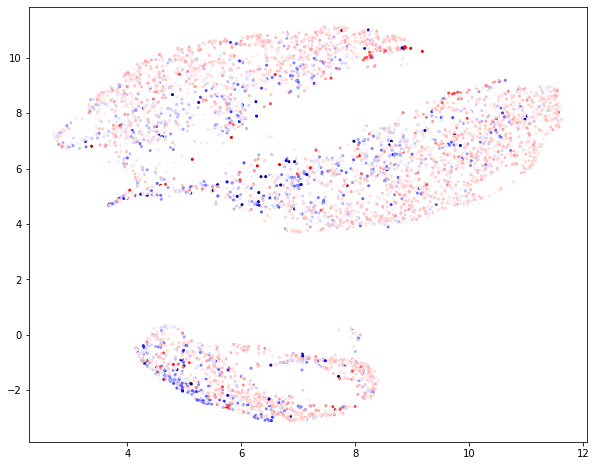

In [270]:
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Create a scatter plot with a color bar
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], s=4, c=c, cmap=cmap)  # Adjust 's' for point size


In [256]:
umap_result.shape

(5001, 2)

In [17]:


def run_multiprocess(func, tasks, n_cores, tasks_per_core=1):
        
    stdout_queue = multiprocessing.Queue()
    pool = multiprocessing.Pool(processes=n_cores, initargs=[stdout_queue], maxtasksperchild=tasks_per_core)
    for i, data in enumerate(pool.starmap(func, tasks), 1):
        yield data
    pool.close()
    pool.join()



In [29]:

pdb_dir = '/home/users/sdunin/calc/HAMPpred/data/input/af2_full'
usexecutable = '/home/users/sdunin/apps/USalign/USalign'

def align(i,j,pdb1, pdb2):
    usexecutable = '/home/users/sdunin/apps/USalign/MMalign'
    
    align_res = subprocess.run(
        [usexecutable, pdb1, pdb2, '-mm', '1', '-ter', '0', '-outfmt', '2'],
        capture_output=True, text=True
    )
    res = align_res.stdout.split('\n')[1].split('\t')
    return [i,j]+res

num_cpus = 15
pool = Pool(processes=num_cpus)

#max_index = len(data_df.index)
max_index = 100

print('generating jobs...')

jobs = []

for i in range(max_index):
    idx1 = data_df.index[i]
    row1 = data_df.loc[idx1]
    pdb1 = os.path.join(pdb_dir, row1.pdb_file)
    
    for j in range(i + 1, max_index):
        idx2 = data_df.index[j]
        row2 = data_df.loc[idx2]
        pdb2 = os.path.join(pdb_dir, row2.pdb_file)

        jobs.append((idx1, idx2, pdb1, pdb2))

jobs_count = len(jobs)
print(f'running {jobs_count} jobs on {num_cpus} cpus...')
        
results = []      
with tqdm(total=jobs_count) as pbar:       
    for res in run_multiprocess(align, jobs, 10):
        results.append(res)
        assert len(res)==13
        pbar.update(10)

generating jobs...
running 4950 jobs on 15 cpus...


49500it [00:38, 1282.17it/s]                                                                                                                                  


In [ ]:
head = ['i', 'j', 'PDBchain1', 'PDBchain2', 'TM1', 'TM2', 'RMSD', 'ID1', 'ID2', 'IDali', 'L1', 'L2', 'Lali']
res_df = pd.DataFrame(results, columns=head)
res_df.to_pickle('./tmp/AF2_clust.p')

In [25]:
len(data_df)

150